In [1]:
# based on human interpretable machine learning - by Dipanjan Sarkar
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
import shap
from collections import Counter
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

In [2]:
# Loading census data

data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])
data.shape, labels.shape

((32561, 12), (32561,))

In [3]:
Counter(labels) # view distribution of the people with <=50k income (False) and >50k (True)

Counter({0: 24720, 1: 7841})

In [4]:
# converting categorical columns with string values to numeric representations. 
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

In [5]:
# now building and traing 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [6]:
%%time

import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

Wall time: 4.43 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [7]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

In [8]:
# model performance evaluation (using the utils function in the same folder as this notebook)
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


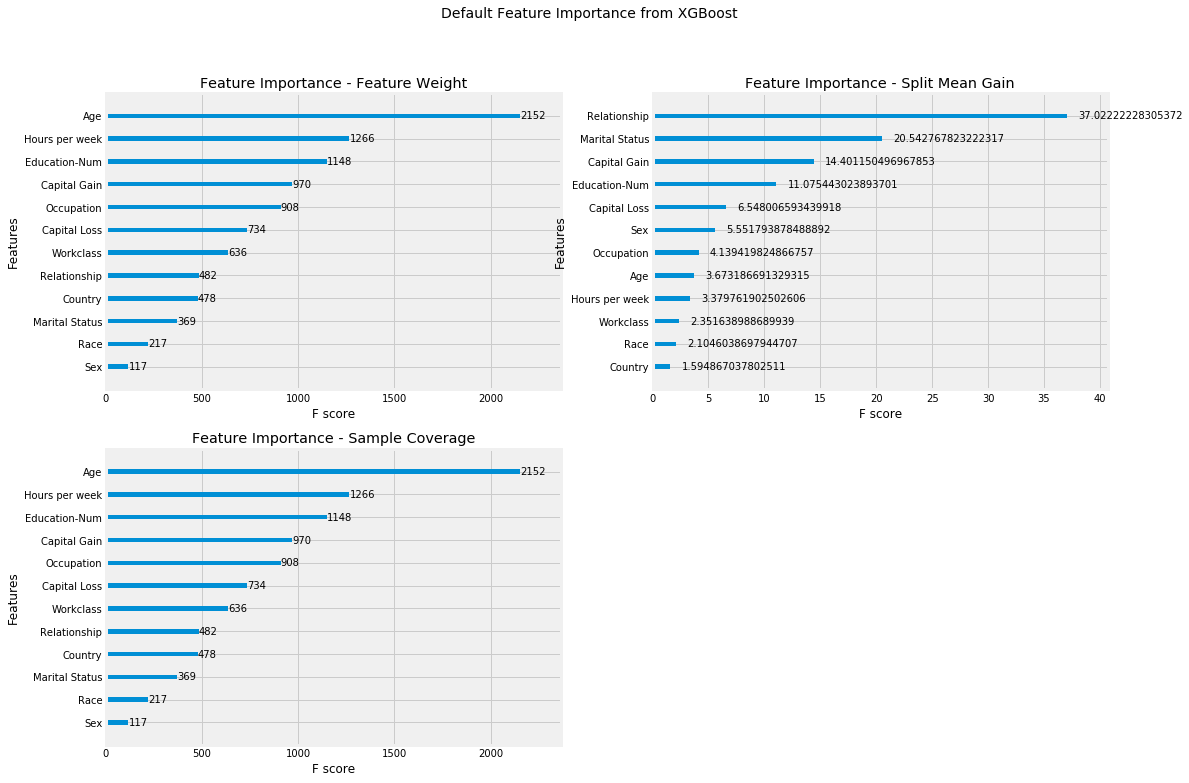

In [9]:
# interpretation

# Default model interpretation
# for non-parametric models
# 1) Feature importance

# XGBoost allows us to view feature importance based on 
# Feature weights: number of times a feature appears in a tree across the ensamble of trees
# Gain: Average gain of splits which use the feature
# Coverage: Average coverage (number of sample  affected) of splits which use the feature

fig = plt.figure(figsize=(16, 12))
title = fig.suptitle("Default Feature Importance from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2,1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2,2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2,3)
xgb.plot_importance(xgc, importance_type='weight', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

In [ ]:
# using ELI5
# ! pip uninstall eli5

In [10]:
from eli5 import show_weights

show_weights(xgc.get_booster())
# shows weights for each feature depicting how influential it might have been contributing to the final prediction decision
# across all cases
# ELI5 is not model-agnostic -- typically the prediction can be defined as the sum of the feature contributions + "bias"

In [11]:
# Predicting when individual income is less than 50K
doc_num = 0
print('Actual Label: ', y_test[doc_num])
print('Predicted Label: ', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num],
               feature_names=list(data.columns), show_feature_values=True)

Actual Label:  0
Predicted Label:  0


In [12]:
# predicting when a person's income is greater than 50k
doc_num = 2
print('Actual Label: ', y_test[doc_num])
print('Predicted Label: ', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num],
               feature_names=list(data.columns), show_feature_values=True)

Actual Label:  1
Predicted Label:  1


In [19]:
# skater
# ! pip install skater

#using Skater
# 1) building interpretation object
# 2) Creating a model (in memory or in deployed)
# 3) Run interpretation
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                        target_names=['$50K or less', 'More than $50k'])

interpreter = Interpretation()
interpreter.load_data(X_test)
interpreter.feature_importance.feature_importance(im_model)

[12/12] features ████████████████████ Time elapsed: 1 seconds

Race              0.012396
Country           0.016985
Sex               0.034556
Capital Loss      0.036798
Workclass         0.041802
Hours per week    0.089476
Occupation        0.112137
Marital Status    0.114713
Relationship      0.116360
Capital Gain      0.133065
Education-Num     0.144006
Age               0.147705
dtype: float64

[12/12] features ████████████████████ Time elapsed: 2 seconds

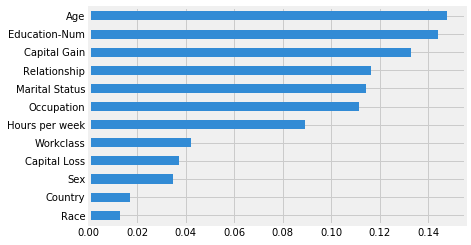

In [22]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

[44/44] grid cells ████████████████████ Time elapsed: 5 seconds

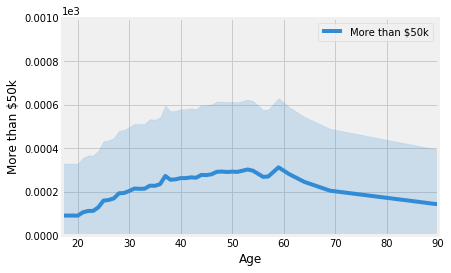

In [23]:
# using partial dependence plot 
# (marginal impact of a feature on model prediction holding other feature constant- analgous to coef in regression)

r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

[16/16] grid cells ████████████████████ Time elapsed: 3 seconds

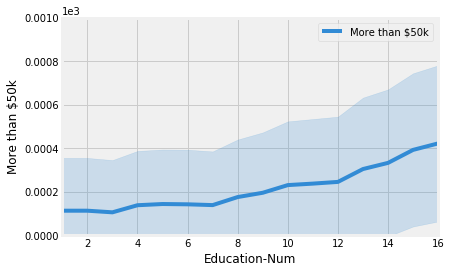

In [24]:
r= interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50,
                                                         grid_range=(0,1), n_samples=23000,
                                                         with_variance=True, figsize=(6,4))
yl= r[0][1].set_ylim(0,1)

[6/6] grid cells ████████████████████ Time elapsed: 2 seconds

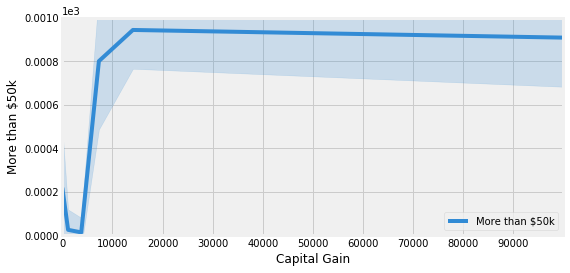

In [25]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

[1136/1136] grid cells ████████████████████ Time elapsed: 81 seconds

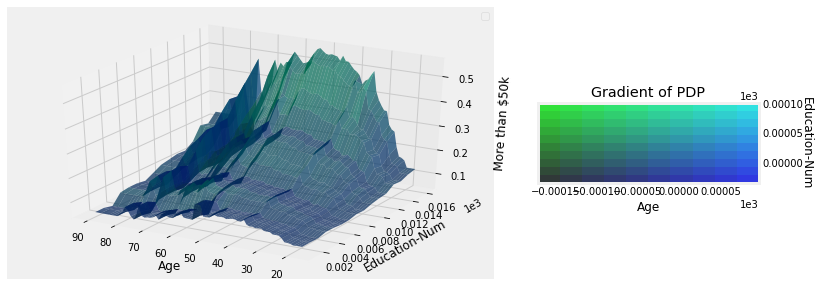

In [27]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

[160/160] grid cells ████████████████████ Time elapsed: 14 seconds

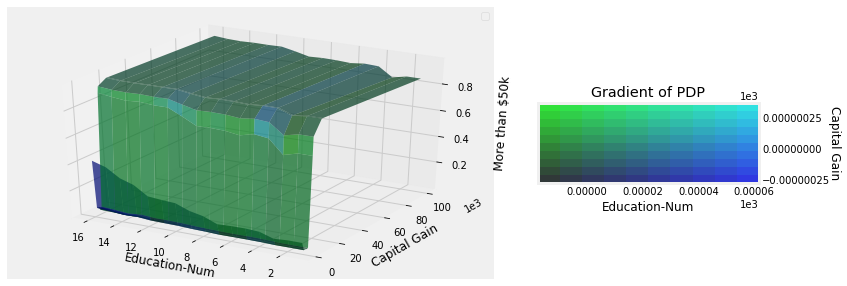

In [28]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

In [29]:
# LIME
# since XGBoost has some issues with feature name ordering when building model with dataframes, to make LIME work
# use numpy arrays

xgc_np = xgb.XGBRFClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                            objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

In [31]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

In [32]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 0
Predicted Label: 0


In [33]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1


In [38]:
# using Tree Surrogate (based on TREPAN algorithm)
# interpreter = Interpretation(X_train, feature_names=list(data.columns))
# model_inst = InMemoryModel(xgc.predict_proba, examples=X_train, 
#                         target_names=['$50K or less', 'More than $50k'])

# surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)

# surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')


In [ ]:
# pd.DataFrame([('X'+str(idx), feature) 
#                    for (idx, feature) in enumerate(data.columns)]).T

In [ ]:
# from skater.util.dataops import show_in_notebook
# from graphviz import Source
# from IPython.display import SVG

# graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
#                                           file_name='test_tree_pre.png').to_string())
# svg_data = graph.pipe(format='svg')
# with open('dtree_structure.svg','wb') as f:
#     f.write(svg_data)
# SVG(svg_data)

In [ ]:
# surrogate_predictions = surrogate_explainer.predict(X_test)
# class_labels = list(set(labels))
# meu.display_model_performance_metrics(true_labels=y_test, 
#                                       predicted_labels=surrogate_predictions, 
#                                       classes=class_labels)

In [39]:
# Modelinterpretation with SHAP
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected value: ', explainer.expected_value)
pd.DataFrame(shap_values).head()

#This returns a matrix of SHAP values (# samples x # features). 
# Each row sums to the difference between the model output for that sample and the expected value of the model output 
# (which is stored as expected_value attribute of the explainer). 
# Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

Expected value:  -1.3625857


0         1         2         3         4         5         6   \
0 -1.209206 -0.003895 -0.073927 -1.078541 -0.645259 -0.517731 -0.002871   
1  0.354368 -0.262398 -0.483883  0.586233  0.307967  1.194750  0.017408   
2 -0.525650  0.030637  0.970991  0.360480  0.528695  0.603971 -0.103895   
3 -0.426095  0.076188  0.576406 -1.108961 -0.517884 -0.522604  0.028896   
4 -0.503867 -0.159754 -0.129339 -0.547773 -0.049194 -0.414065 -0.019701   

         7         8         9         10        11  
0 -0.421329 -0.144742 -0.036394 -0.568053 -0.004587  
1 -0.216272 -0.108322 -0.048158 -0.095782  0.017657  
2  0.050630 -0.176231 -0.087669  0.509656  0.024573  
3 -0.359870 -0.142805 -0.057430 -0.250736  0.023183  
4  0.128197 -3.685364 -0.031033  0.781617  0.001285

In [40]:
# predicting when a person's income is less than 50k
shap.force_plot(explainer.expected_value, 
               shap_values[0,:], X_test.iloc[0,:])

In [41]:
shap.force_plot(explainer.expected_value,
               shap_values[2,:], X_test.iloc[2,:])

In [42]:
# visualizing and explaining multiple predictions
shap.force_plot(explainer.expected_value, 
               shap_values[:1000, :], X_test.iloc[:1000,:])

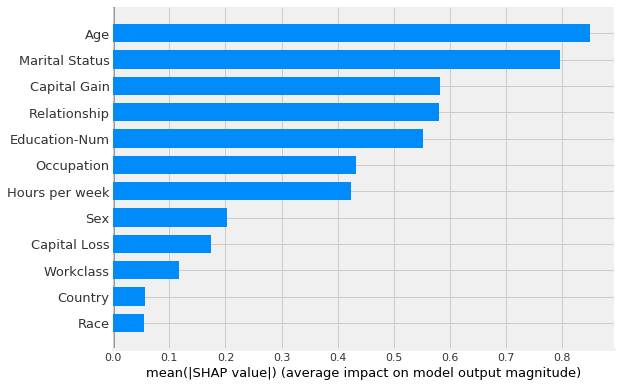

In [43]:
# Shap summary plot (Takes the average of the shap value magnitudes across the dasaset and plots it)
shap.summary_plot(shap_values,
                 X_test, plot_type='bar')

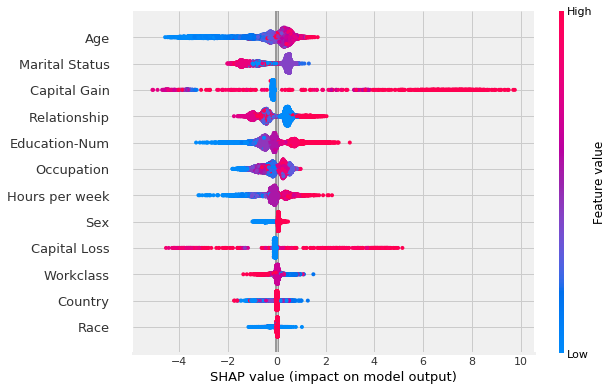

In [44]:
# it also gives a density scatter plot of shap values for each feature to identfiy how much impact each feature has on output
shap.summary_plot(shap_values, X_test)

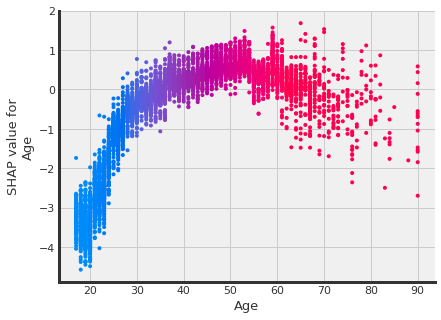

In [47]:
# Shap pdp (show the effect of a single or two feature across the whole dataset)

shap.dependence_plot(ind='Age', interaction_index='Age',
                    shap_values=shap_values,
                    features=X_test,
                    display_features=X_test)

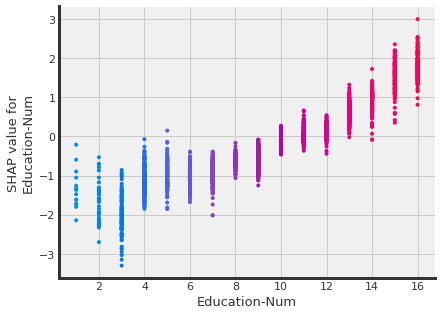

In [48]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

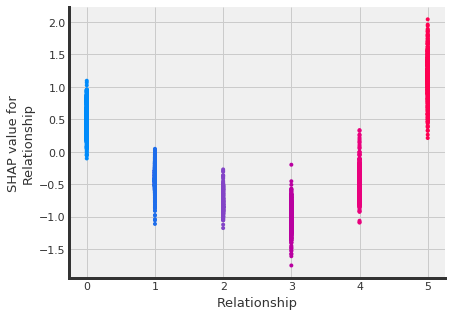

In [49]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

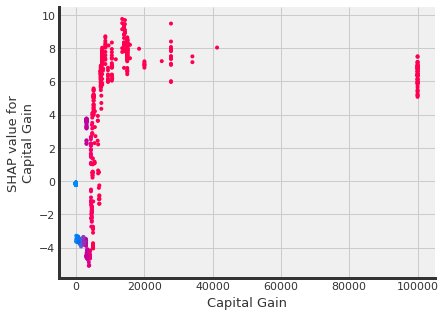

In [50]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

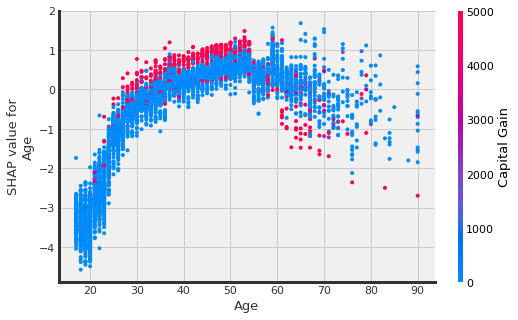

In [51]:
# two-way
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

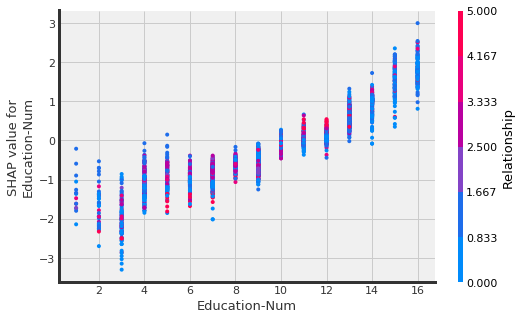

In [52]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)